In [1]:
import numpy as np
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import pandas as pd

from torch.nn.utils import _stateless


# Plot EXP2

### Function definitions

In [2]:
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs','g_weight', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        result_details[key] = val
    return result_details

def get_exp_results(r_det, alternate_analysis = False):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        gen_err_list.append(t_list)
        
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    gen_err_list = np.array(gen_err_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    print('gen err list shape:',gen_err_list.shape)
    
    # K_g = np.max(np.mean(np.array(grad_list), 0))
    # L_g = np.max(np.mean(np.array(hess_list), 0))
    
    # IMP: note that here we use older paper's notation where K_g is lipschitz constant(L_S) and L_g is the smoothness constant (K_S)
    K_g = np.max(np.max(np.array(grad_list), 1))
    L_g = np.max(np.max(np.array(hess_list), 1))
    
    if alternate_analysis:
        # For alternate analysis we compute the average Lipschitz constant acc to latest paper (L_{S,I_0})
        # i.e., E_{w_0,r}[L_{S,I_0}]  (there will be other variables in expectation as well)
        K_st = np.sqrt(np.mean(np.mean(np.power(np.array(grad_list),2),1)))
    ### MNIST
    K_g_avg = np.mean(grad_list)
    L_g_avg = np.mean(hess_list)
    K_g_run_avg = []
    L_g_run_avg = []
    for i, kgi in enumerate(np.max(grad_list, 0)):
        temp = np.sqrt(np.mean(np.mean(np.power(grad_list,2), 0)[:i+1]))
        K_g_run_avg.append(temp)
    for i,lgi in enumerate(np.max(hess_list, 0)):
        temp = np.mean(np.max(hess_list, 0)[:i+1])
        L_g_run_avg.append(temp)
        
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by

    if alternate_analysis:
        return grad_list, hess_list, K_st, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg
    else:
        return grad_list, hess_list, K_g, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg
    




In [3]:
from scipy.special import gammaincc as incomplete_gamma

def clac_U(x, rho, alpha_0, L_g, way = 'other'):

    # print(f'{1 - 2*rho =}')
    # if(1-2*rho <0):
        ## very small value of m
        # return 1 + 1/(L_g*alpha_0)
    if way == 'other':
        base_const = np.exp(-2*alpha_0*L_g/rho)
        temp_res = 0
        for i in range(2, x+1):
            temp_res += np.exp(-2 *alpha_0 * L_g * np.power(i, rho)/rho)/np.power(i, 1-rho)
        
        return base_const + temp_res
            

    else:
        base_const = np.exp(-2*alpha_0*L_g/rho)
        gamma_const = (1/(1-2*rho))*np.power(2*alpha_0*L_g/rho, (1/rho - 2))
        input_1 = (2*rho -1)/rho
        input_2 = 2*alpha_0*L_g /rho
        print(f'{input_1=}, {input_2=}')
        gamma_function = incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g* np.power(x, rho)/rho) - incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g/rho)
        print(f'{gamma_function=}')
    
    return base_const + gamma_const* gamma_function

def our_bound_computatio(K_g, L_g, m, t, alpha_0, way='normal'):
    '''
    IMP: (Here we use older paper's notation)
        K_g = lipschitz constant 
        L_g = smoothness constant
    '''
    beta = 1
    alpha_lg = alpha_0*L_g
    # print('alpha_0 L_g (<=0.25?):',alpha_lg)
    if way == 'normal':
        F = np.power(t/m, 2*alpha_lg)
        F = F*np.power(2, t/m)
        # print('F', F)
        beta = (1+alpha_lg)*np.power(K_g,2)/L_g
        beta = beta* F/(np.power(m, 1-2*alpha_lg))
    est_gen_err = beta + 2*beta*np.sqrt(m)
    return est_gen_err

# New bound computation method


def get_bound(r_det, K_g, L_g, version = None):
    alpha_0 = r_det['alpha_0']
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            if version == 'TMLR':
                x_values.append(i+10)
            else:
                x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    x_values = np.array(x_values)
    print('x value shape:', x_values.shape)        
    m = x_values
    t = m
    # print('shape of m',m.shape)
    # print('m:',m)
    if version is None:
        bound = our_bound_computatio(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0)
    # elif version == 'TMLR':
    #     bound = our_bound_computation_tmlr(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0, way = 'optimistic')
    return bound

def plot_bound_gen_err(bound, gen_error, path=None, ylimits = None, x_values=None, title=None):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_yscale('log')
    fontsize = 40
    ticksize = 24
    line_width = 6
    marker_size = 12
    if ylimits is not None:
        ax.set_ylim(ylimits[0],ylimits[1])
    if x_values is None:
        x_values = range(len(gen_error[0]))
    # ax.grid()
    sns.set_style("darkgrid")
    plt.plot(x_values, bound, label= 'Theoretical Upper Bound')
    plt.plot(x_values, np.abs(np.mean(gen_error, axis=0)), label='Observed Generalization Error')
    plt.xlabel('Number of Datapoints', fontsize=fontsize)
    plt.ylabel('Generalization error', fontsize=fontsize)
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    plt.xticks(rotation=10, size= ticksize)
    plt.yticks(size=ticksize)
    # ax.set_yticks(ax.get_yticks()[1:])
    # ax.set_yticklabels(ax.get_yticks(), size = ticksize)
    # ax.set_yscale('log')
    plt.xlim(-100, plt.xlim()[1])
    ax.legend(fontsize=ticksize)
    # ax.legend()
    plt.tight_layout()
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if path is not None:
        plt.savefig(path, pad_inches=0)

In [4]:
from scipy.special import gammaincc as incomplete_gamma

def clac_U(x, rho, alpha_0, L_g, way = 'other'):

    # print(f'{1 - 2*rho =}')
    # if(1-2*rho <0):
        ## very small value of m
        # return 1 + 1/(L_g*alpha_0)
    if way == 'other':
        base_const = np.exp(-2*alpha_0*L_g/rho)
        temp_res = 0
        for i in range(2, x+1):
            temp_res += np.exp(-2 *alpha_0 * L_g * np.power(i, rho)/rho)/np.power(i, 2-2*rho)
        
        return base_const + temp_res
            

    else:
        base_const = np.exp(-2*alpha_0*L_g/rho)
        gamma_const = (1/(1-2*rho))*np.power(2*alpha_0*L_g/rho, (1/rho - 2))
        input_1 = (2*rho -1)/rho
        input_2 = 2*alpha_0*L_g /rho
        print(f'{input_1=}, {input_2=}')
        gamma_function = incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g* np.power(x, rho)/rho) - incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g/rho)
        print(f'{gamma_function=}')
    
    return base_const + gamma_const* gamma_function

def get_exp_results_tmlr(r_det, avg_lp = 'avg'):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        gen_err_list.append(t_list)
        
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    gen_err_list = np.array(gen_err_list)
    # print('hess list shape:',hess_list.shape)
    # print('grad list shape:',grad_list.shape)
    # print('gen err list shape:',gen_err_list.shape)
    
    # IMP:
    # We use the new notation i.e., L_g, and L_S are (gradient bounds) lipschitz constant and K_s is the smoothness constant
    # print(f'{grad_list.shape=}')
    if avg_lp == 'avg':
        L_s = []
        L_g = []
        for i in range(grad_list.shape[1]):
            L_s.append(np.mean(np.power(grad_list[:,:i+1],2)))
            L_g.append(np.mean(grad_list[:,i]))
        L_s = np.sqrt(np.array(L_s))
        L_g = np.array(L_s)
    elif avg_lp == 'arg_max':
        L_s = np.max(np.max(grad_list, 1))
        L_g = np.max(grad_list)
    elif avg_lp == 'avg_ls':  # Not is use, this computes different ls for every value of 'm'
        L_s = []
        L_g = []
        for i in range(grad_list.shape[1]):
            L_s.append(np.mean(np.max(grad_list[:,:i+1], axis=1)))
            L_g.append(np.max(grad_list[:,:i+1]))
        L_s = np.array(L_s)
        L_g = np.array(L_s)
        
    K_s = np.max(np.max(hess_list,1))
    
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by

    return L_g, L_s, K_s, x_values, gen_err_list


def our_bound_computation_tmlr(L_s, L_g, K_s, m, t, alpha_0, way= 'avg'):
    beta = 1
    if way == 'arg_max':
        # for worst case L_s across the training
        alpha_kg = alpha_0 * K_s
        rho = np.log(np.log(m))/np.log(m)
        U = 1 + 1/(alpha_kg)
        beta = np.power(2,np.ceil(t/m))*alpha_0*L_s*L_g*U* np.power(np.log(m),2) * np.power(m, alpha_kg/rho)
        est_gen_err = beta /m
    elif way == 'avg':
        # assuming L_s is squared avg and then sqrt is taken, i.e.,
        # sqrt(E[k_g^2])
        K_s = K_s
        m = m+10  # to handle log log m
        U = np.sqrt(1 + 1/(2*alpha_0 * K_s))
        m_exp = 0.5 - alpha_0 * K_s * (np.log(m) -1)/np.log(np.log(m))
        # print(f'{m_exp=}')
        est_gen_err = alpha_0 * L_s*L_g* U * np.power(np.log(m),2) / np.power(m, m_exp)
    elif way == 'exact_sum':  # Experimental, to see which quantities actually gives better plot
        # Using best possible value of U (Calculating summation)
        # assuming L_s is squared avg and then sqrt is taken, i.e.,
        # sqrt(E[L_s^2])
        est_gen_err = []
        skip_top = 10
        # K_s = np.max(K_s)
        for idx, x in enumerate(m[skip_top:]):
            if type(L_s) == list or type(L_s) == np.ndarray:
                # print(f'\n\n\n Taking ls as 1 element \n\n\n')
                tLs = L_s[idx+skip_top]
            else:
                tLs = L_s
            if type(L_g) == list or type(L_g) == np.ndarray:
                # print(f'\n\n\n Taking ls as 1 element \n\n\n')
                tLg = L_g[idx+skip_top]
            else:
                tLg = L_g

            rho = np.log(np.log(x))/np.log(x)
            # rho = alpha_0* K_s
            # U = np.exp(-2 * alpha_0* K_s/rho)
            U = clac_U(x,rho,alpha_0, K_s)
            # print(f'{U=}')
            temp_res = alpha_0 *tLs*tLg* U * np.power(np.log(x), 2)/np.power(x, 0.5 - alpha_0 * K_s/rho)
            # print(f'{temp_res=}')
            est_gen_err.append(temp_res)
        est_gen_err = [1]*skip_top + est_gen_err
        # print(est_gen_err)
        est_gen_err = np.array(est_gen_err)
        # print(est_gen_err)
    elif way == 'using_gamma_func':
        raise Exception('complete this function')
    else:
        raise Exception('Undefined avg_lg')
     
    return est_gen_err


def get_bound_tmlr(r_det, L_s, L_g, K_s, avg_lg = 'avg'):
    alpha_0 = r_det['alpha_0']
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            # if version == 'TMLR':
            #     x_values.append(i+10)
            # else:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    x_values = np.array(x_values)
    # print('x value shape:', x_values.shape)        
    m = x_values
    t = m
    # print('shape of m',m.shape)
    # print('m:',m)
    bound = our_bound_computation_tmlr(L_s = L_s, L_g=L_g, K_s=K_s, m=m, t=t, alpha_0=alpha_0, way = avg_lg)
    return bound

In [6]:
def plot_stability_e2(bound, gen_error, x_values, path = None, type='mnist'):
    ## Resetting sns params
    if type == 'mnist':
        ylimit = (0.0000001, 500)
    elif type == 'fmnist':
        ylimit = (0.0005, 100)
    sns.set_theme()
    ## Applying locally
    with sns.axes_style('ticks'):
        sns.set_context('talk')
        plt.yscale('log')
        plt.plot(x_values, bound, label= 'Theoretical Upper Bound')
        plt.plot(x_values, np.abs(np.mean(gen_error, axis=0)), label='Observed Generalization Error')
        plt.xlabel('Number of Datapoints')
        plt.ylabel('Generalization error')
        plt.ylim(ylimit[0], ylimit[1])
        plt.legend()
        if path is not None:
            plt.savefig(path, bbox_inches='tight', dpi=300)
    return

## Running for main experiment (Without Second moment)

#### Mnist

In [5]:
root_dir = 'results/t1.1/'
path = 'try2_t10_r.4'
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
bound_avg = get_bound(details,K_g_avg, L_g_avg) 
bound_run_avg=[]
for i in range(min(len(K_g_run_avg), len(L_g_run_avg))):
    kg, lg= K_g_run_avg[i], L_g_run_avg[i]
    m = t = x_values[i]
    alpha_0 = details['alpha_0']
    # print('m',m)
    bound_run_avg.append(our_bound_computatio(kg, lg, t,m, alpha_0))

print('Lp const:',K_g,'sm cons:', L_g)
# Using global average Lipschitz and smoothness
# plot_bound_gen_err(bound_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_avg.png')

# Using running average Lip and Sm
# plot_bound_gen_err(bound_run_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_run_avg.pdf')

# Using global max Lip and Sm
## Commented old plot function
# plot_bound_gen_err(bound, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist.pdf')

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


NameError: name 'get_bound' is not defined

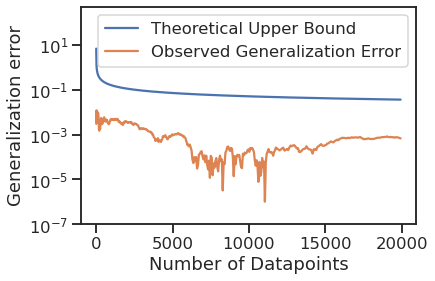

In [66]:
# plot_stability_e2(bound, gen_err_list, x_values, path='e2_generalization_error_mnist.pdf', type='mnist')
plot_stability_e2(bound, gen_err_list, x_values, path=None, type='mnist')

#### Fashion MNIST

In [63]:
root_dir = 'results/t2.2/'
path = 'try2f_t8_r.4'
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
bound_avg = get_bound(details,K_g_avg, L_g_avg) 
bound_run_avg=[]
for i in range(min(len(K_g_run_avg), len(L_g_run_avg))):
    kg, lg= K_g_run_avg[i], L_g_run_avg[i]
    m = t = x_values[i]
    alpha_0 = details['alpha_0']
    # print('m',m)
    bound_run_avg.append(our_bound_computatio(kg, lg, t,m, alpha_0))

print('Lp const:',K_g,'sm cons:', L_g)
# Using global average Lipschitz and smoothness
# plot_bound_gen_err(bound_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_avg.png')

# Using running average Lip and Sm
# plot_bound_gen_err(bound_run_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_Fmnist_run_avg.png')

# Using global max Lip and Sm
## Commented old plot code
# plot_bound_gen_err(bound, gen_err_list, x_values=x_values, path='e2_generalization_error_Fmnist.pdf')

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)
x value shape: (400,)
x value shape: (400,)
Lp const: 11.6964 sm cons: 110.4085


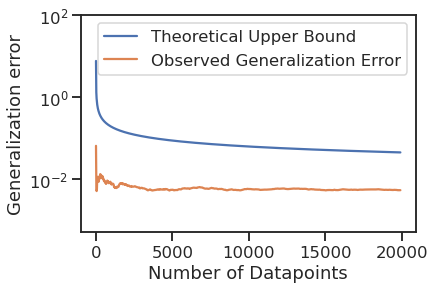

In [64]:
## New Plot
plot_stability_e2(bound, gen_err_list, x_values, path='e2_generalization_error_Fmnist.pdf', type='fmnist')

## TMLR version (with Second moment of Gradients)

In [24]:
# Plotting function
def plot_generalization_bounds(bound_avg, bound_wc, gen_err, x_values, type = 'mnist', path = None):
    if type == 'mnist':
        ylimit = (0.0000001, 1000)
    elif type == 'fmnist':
        ylimit = (0.0005, 100)
    sns.set_theme()
    ## Applying locally
    with sns.axes_style('ticks'):
        sns.set_context('talk')
        # fig, ax = plt.subplots(figsize = (6,3.5))
        plt.yscale('log')
        # plt.plot(x_values[10:], bound_exact[10:], label= 'Alternate Exact Bound')
        # plt.plot(x_values[10:], bound[10:], label= 'Bound')
        plt.plot(x_values[10:], bound_avg[10:], label= 'via Second Moment of Gradient')
        plt.plot(x_values[10:], bound_wc[10:], label= 'via Worst Case Gradient')
        plt.plot(x_values[10:], np.abs(np.mean(gen_err, axis=0))[10:], label='Observed Generalization Error')
        plt.xlabel('Number of Datapoints')
        plt.ylabel('Generalization error')
        plt.ylim(ylimit[0], ylimit[1])
        plt.legend()
        if path is not None:
            plt.savefig(path, bbox_inches='tight', dpi=300)

### MNIST

In [20]:
root_dir = 'results/t1.1/'
path = 'try2_t10_r.4'
# root_dir = 'results/t2.2/'
# path = 'try2f_t8_r.4'
details = get_exp_details(root_dir, path)

# grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
# bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
# print('------------------------------')

print('Worst Case Lipschitz constant (gradient bound).')
L_g, L_s, K_s, x_values, gen_err_list = get_exp_results_tmlr(details, avg_lp='arg_max')
prev_bound = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='arg_max')
print(f'{L_g=}, {L_s=}, {K_s=}')

print('------------------------------')
print()
print('Second moment of Lipschitz constant (gradient bound).')
L_g, L_s, K_s, x_values, gen_err_list = get_exp_results_tmlr(details, avg_lp='avg')
bound_avg = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='avg')
print(f'L_g={L_g.max()}, L_s={L_s.max()}, {K_s=}')

print('------------------------------')
print()
print('Not in use, Exact sum bound, using exact U()\' instead of the upper bound that we used.')
# L_g, L_s, K_s, x_values = get_exp_results_tmlr(details, avg_lp='avg')
bound_exact = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='exact_sum')
print(f'L_g={L_g.max()}, L_s={L_s.max()}, {K_s=}')
print('------------------------------')

# print('Lip consts:',L_g, L_s,'sm cons:', K_s)

Worst Case Lipschitz constant (gradient bound).
L_g=8.1233, L_s=8.1233, K_s=58.1694
------------------------------

Second moment of Lipschitz constant (gradient bound).
L_g=4.111578505270208, L_s=4.111578505270208, K_s=58.1694
------------------------------

Not in use, Exact sum bound, using exact U()' instead of the upper bound that we used.


/tmp/ipykernel_55763/1445737805.py:120: RuntimeWarning: divide by zero encountered in log
  rho = np.log(np.log(m))/np.log(m)


L_g=4.111578505270208, L_s=4.111578505270208, K_s=5.81694e+01
------------------------------


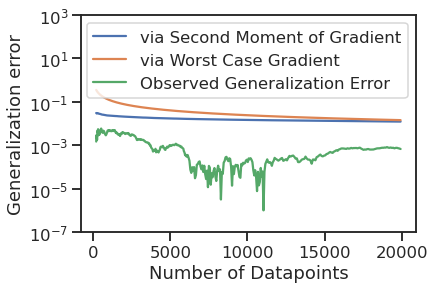

In [25]:
plot_generalization_bounds(bound_avg=bound_avg, bound_wc=prev_bound, gen_err=gen_err_list, x_values=x_values, type='mnist', path= 'e2_generalization_error_mnist.pdf')

### FMNIST

In [17]:
root_dir = 'results/t2.2/'
path = 'try2f_t8_r.4'
details = get_exp_details(root_dir, path)

# grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
# bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
# print('------------------------------')

print('Worst Case Lipschitz constant (gradient bound).')
L_g, L_s, K_s, x_values, gen_err_list = get_exp_results_tmlr(details, avg_lp='arg_max')
prev_bound = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='arg_max')
print(f'{L_g=}, {L_s=}, {K_s=}')

print('------------------------------')
print('Second moment of Lipschitz constant (gradient bound).')
L_g, L_s, K_s, x_values, gen_err_list = get_exp_results_tmlr(details, avg_lp='avg')
bound_avg = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='avg')
print(f'L_g={L_g.max()}, L_s={L_s.max()}, {K_s=}')

print('------------------------------')
print('Not in use, Exact sum bound, using exact U()\' instead of the upper bound that we used.')
# L_g, L_s, K_s, x_values = get_exp_results_tmlr(details, avg_lp='avg')
bound_exact = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='exact_sum')
print(f'L_g={L_g.max()}, L_s={L_s.max()}, {K_s=}')
print('------------------------------')

# print('Lip consts:',L_g, L_s,'sm cons:', K_s)

Worst Case Lipschitz constant (gradient bound).
L_g=11.6964, L_s=11.6964, K_s=110.4085
------------------------------
Second moment of Lipschitz constant (gradient bound).
L_g=5.440500100002296, L_s=5.440500100002296, K_s=110.4085
------------------------------
Not in use, Exact sum bound, using exact U()' instead of the upper bound that we used.


/tmp/ipykernel_55763/1445737805.py:120: RuntimeWarning: divide by zero encountered in log
  rho = np.log(np.log(m))/np.log(m)


L_g=5.440500100002296, L_s=5.440500100002296, K_s=1.104085e+02
------------------------------


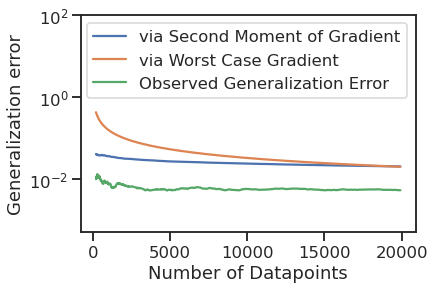

In [18]:
plot_generalization_bounds(bound_avg=bound_avg, bound_wc=prev_bound, gen_err=gen_err_list, x_values=x_values, type='fmnist', path='e2_generalization_error_Fmnist.pdf')

## Rough

In [11]:
details['alpha_0']

0.0001

In [8]:

result_dcit = {}
result_dcit['Lipschitz constant'] = K_g_run_avg #np.sqrt(np.mean(np.power(np.array(grad_list),2)))
result_dcit['Alternate Bound'] = bound_avg
result_dcit['Prev Bound'] = prev_bound
result_dcit['Generalization error'] =  np.abs(np.mean(gen_err_list, axis=0))
result_df = pd.DataFrame(result_dcit)
result_df.iloc[10::20]#.head(30)

,Lipschitz constant,Alternate Bound,Prev Bound,Generalization error
10,3.916798,0.030644,0.352212,0.001492
30,3.864364,0.026352,0.176742,0.003844
50,3.835556,0.020658,0.125624,0.004513
70,3.861488,0.020757,0.099750,0.005003
90,3.878500,0.022664,0.083743,0.003521
110,3.879938,0.021129,0.068372,0.002906
130,3.882439,0.020050,0.055682,0.001752
150,3.880774,0.017588,0.047409,0.000560
170,3.880220,0.016234,0.041530,0.000874
190,3.890261,0.015697,0.037107,0.000972


In [13]:
bound_exact.shape, bound_avg.shape, prev_bound.shape

((400,), (400,), (400,))

In [14]:
bound_avg

array([0.02155926, 0.03648784, 0.0263741 , 0.03148544, 0.0260803 ,
       0.02592675, 0.02814286, 0.03499392, 0.02793537, 0.03059138,
       0.03064434, 0.02233709, 0.03485441, 0.02722862, 0.0317978 ,
       0.02599506, 0.03324001, 0.02529469, 0.02496905, 0.02559256,
       0.02440212, 0.02788828, 0.02879814, 0.02302985, 0.02411285,
       0.02784468, 0.02404673, 0.02244063, 0.01984115, 0.02295571,
       0.02635164, 0.02444789, 0.02526661, 0.02410925, 0.02006123,
       0.02224915, 0.02215351, 0.02216623, 0.02727117, 0.02149341,
       0.02306884, 0.02313571, 0.02142056, 0.02290634, 0.01978105,
       0.02452988, 0.02631513, 0.02125639, 0.0237088 , 0.02374252,
       0.0206577 , 0.02446456, 0.02142103, 0.02325918, 0.02465284,
       0.02475526, 0.01641096, 0.02017993, 0.02387614, 0.02291918,
       0.0269198 , 0.0175676 , 0.02146951, 0.01902943, 0.02451426,
       0.02166385, 0.02370599, 0.0188142 , 0.02324893, 0.02423926,
       0.02075674, 0.01979039, 0.02691835, 0.02536611, 0.02121